### Libraries

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

### Get Data

In [183]:
with open('./data/processed/codes_to_city_dict.txt', 'rb') as handle:
    codes_to_city = pickle.loads(handle.read()) # Dictionary mapping IATA codes to city names
dat = pd.read_pickle('./data/processed/final/all-sched.pkl')
dat.head()

,operator,flight,aircraft,frequency,from,from_time,to,to_time,eff_from,eff_to
0,IND,6E 101,A 320,"[1, 2, 3, 4, 5, 6, 7]",MAA,6.25,CJB,7.25,2019-10-27 00:00:00,2020-03-28 00:00:00
1,IND,6E 103,A 320,"[1, 2, 3, 4, 5, 6, 7]",PNQ,22.33,BLR,0.08,2019-10-27 00:00:00,2020-03-28 00:00:00
2,IND,6E 104,A 320,"[1, 2, 3, 4, 5, 6, 7]",HYD,8.17,ATQ,11,2019-10-27 00:00:00,2020-03-28 00:00:00
3,IND,6E 105,A 320,"[1, 2, 3, 4, 5, 7]",PNQ,17.33,BLR,18.92,2019-10-27 00:00:00,2020-03-28 00:00:00
4,IND,6E 105,A 320,"[1, 2, 3, 4, 5, 7]",DEL,14.75,PNQ,16.83,2019-10-27 00:00:00,2020-03-27 00:00:00


#### Overview

In [184]:
# Adding a column to the dataframe that translates the frequency information into weekly number of flights
dat['weekly_flights'] = dat.apply(lambda row: len(row.frequency), axis = 1)
n_flights = dat['weekly_flights'].sum()
operators = dat['operator'].unique()
n_operators = len(operators)
cities = list(set(dat['from'].tolist() + dat['to'].tolist()))
n_cities = len(cities)

print('In a week, %i operators run %i domestic flights flights into and out of %i Indian cities.\n' % 
      (n_operators, n_flights, n_cities))
print('A flight departs from and arrives into a different city, so the %i flights result in' % n_flights)
print('%i total arrivals and departures.' % (2*n_flights))

In a week, 9 operators run 21954 domestic flights flights into and out of 102 Indian cities.

A flight departs from and arrives into a different city, so the 21954 flights result in
43908 total arrivals and departures.


#### Top Cities by Traffic

Create a new dataframe that captures the total weekly flights (across all carriers) in and out of a city and infer the total number of flights (incoming and outgoing) at the city. Finally, arrange the rows in the descending order of the total number of flights.

Identify the top cities that account for 80% of all flights.

20 cities account for 80% of all arrivals and departures.

Cities accounting for 80% of all arrivals and departures:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Jaipur', 'Lucknow', 'Patna', 'Kochi', 'Bhubaneswar', 'Varanasi', 'Indore', 'Coimbatore', 'Bagdogra', 'Chandigarh']


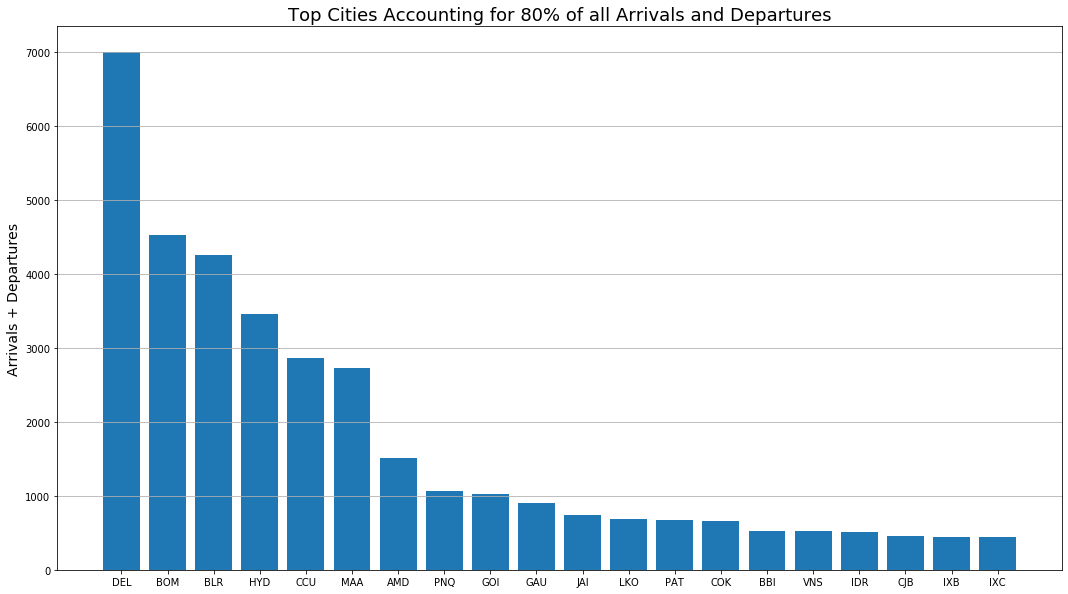

In [185]:
flights_from = dat.groupby(['from'])['weekly_flights'].sum()
flights_to = dat.groupby(['to'])['weekly_flights'].sum()
city_weekly = pd.DataFrame(data = pd.concat([flights_from, flights_to], axis = 1, ignore_index = True))
city_weekly = city_weekly.fillna(0, axis = 1, downcast = 'infer') # if there are no flights either from or 
                                                                  # to a city, replace NA by 0
city_weekly = city_weekly.rename(columns = {0:'from', 1:'to'}, errors = 'raise')
city_weekly['total'] = city_weekly.apply(lambda row : row['from'] + row['to'], axis = 1)
city_weekly = city_weekly.sort_values(by = ['total'], ascending = False)

city_weekly['%_of_total'] = round(city_weekly['total'].cumsum()/(2*n_flights), 2)

top_cities_code = city_weekly.loc[city_weekly['%_of_total'] <= 0.8, :].index.tolist()
top_cities = [codes_to_city[top_cities_code[i]] for i in range(len(top_cities_code))]

print('%i cities account for 80%% of all arrivals and departures.\n' % len(top_cities_code))
print('Cities accounting for 80% of all arrivals and departures:\n', top_cities)

plt.figure(figsize = (18, 10))
plt.bar(top_cities_code, city_weekly['total'][0:len(top_cities)])
plt.title('Top Cities Accounting for 80% of all Arrivals and Departures', size = 18)
plt.ylabel('Arrivals + Departures', size = 14)
plt.show()

#### Day of Week Variations Across Top Cities

<ol>
    <li>Only consider schedules that either begin or end at one of the top cities.
    <li>Keep only columns that are required for analysis - 'frequency', 'from', 'to'.
    <li>One-hot encode frequency: Create 7 new columns, one for each day of the week and if a particular schedule flies on a given day of the week, set value in the appropriate column to True.
    <li>For the top 20 cities, find the total arrivals and departures for every day of the week.
    <li>Plot for each city the total arrivals and departures for every day of the week.
</ol>

In [194]:
# Step 1 and 2
idx = [i for i in range(dat.shape[0]) if dat['from'][i] in top_cities_code or dat['to'][i] in top_cities_code]
new_dat = dat.iloc[idx, :]
new_dat = new_dat.loc[:, ['frequency', 'from', 'to']]
new_dat = new_dat.reset_index(drop = True)

# Step 3
for i in range(1, 8, 1):
    col_name = 'day_' + str(i)
    new_dat[col_name] = False
for i in range(new_dat.shape[0]):
    for j in range(1, 8, 1):
        if j in new_dat['frequency'][i]:
            col_name = 'day_' + str(j)
            new_dat[col_name][i] = True

#Step 4
city_by_day = pd.DataFrame(data = None, columns = ['day_1', 'day_2', 'day_3', 'day_4', 'day_5', 
                                                   'day_6', 'day_7', ])
for i in range(1, 8, 1):
    col_name = 'day_' + str(i)
    from_ = new_dat.groupby(['from'])[col_name].sum()
    to_ = new_dat.groupby(['to'])[col_name].sum()
    total_ = from_ + to_
    city_by_day[col_name] = total_
idx = [i for i in range(city_by_day.shape[0]) if city_by_day.index[i] in top_cities_code]
city_by_day = city_by_day.iloc[idx, :]
city_by_day = city_by_day.reset_index()
city_by_day = city_by_day.rename(columns = {'index' : 'city', 'day_1' : 'MON', 'day_2' : 'TUE', 
                                            'day_3' : 'WED', 'day_4' : 'THU', 'day_5' : 'FRI', 
                                            'day_6' : 'SAT', 'day_7' : 'SUN'})

#Step 5

/home/sanjeev/anaconda3/envs/airtraffic/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
